In [1]:
# lets take a deeper look.
import arrayfire as af

layer_x = af.array.read_array("OUTPUT_TRF.arr", key="layer_x").to_ndarray()

MHAttention_v = af.array.read_array("OUTPUT_TRF.arr", key="MHAttention_v").to_ndarray()
MHAttention_result_attn = af.array.read_array("OUTPUT_TRF.arr", key="MHAttention_result_attn").to_ndarray()
MHAttention_result_result = af.array.read_array("OUTPUT_TRF.arr", key="MHAttention_result_result").to_ndarray()
MHAttention_result_result_2 = af.array.read_array("OUTPUT_TRF.arr", key="MHAttention_result_result_2").to_ndarray()

selfAttention_result = af.array.read_array("OUTPUT_TRF.arr", key="selfAttention_result").to_ndarray()
selfAttention_wf_ = af.array.read_array("OUTPUT_TRF.arr", key="selfAttention_wf_").to_ndarray()
selfAttention_result_2 = af.array.read_array("OUTPUT_TRF.arr", key="selfAttention_result_2").to_ndarray()

layer_selfAttnResult = af.array.read_array("OUTPUT_TRF.arr", key="layer_selfAttnResult").to_ndarray()
layer_norm1_w = af.array.read_array("OUTPUT_TRF.arr", key="layer_norm1_w").to_ndarray()
layer_norm1_b = af.array.read_array("OUTPUT_TRF.arr", key="layer_norm1_b").to_ndarray()
layer_h = af.array.read_array("OUTPUT_TRF.arr", key="layer_h").to_ndarray()
layer_h_2 = af.array.read_array("OUTPUT_TRF.arr", key="layer_h_2").to_ndarray()

In [2]:
# testing again after chaning MCTCSelfOutput to this differnt way flashlight seems to do things

# testing after fixing the model & weights
import torch
from transformers import MCTCForCTC, MCTCProcessor, MCTCConfig
config = MCTCConfig()
model = MCTCForCTC(config)
model.load_state_dict(torch.load("./ported_pytorch_model.bin"))
model = model.eval()
our_attn = model.mctc.encoder.layers[0].attention
first_layer = model.mctc.encoder.layers[0]


In [3]:
def valueprint(k, name=None):
    print(name, k.shape, k.sum(), k.std())

first_layer = model.mctc.encoder.layers[0]

our_output = torch.Tensor(layer_x).unsqueeze(0).transpose(1,2)
valueprint(our_output, "INPUT")
context_layer, attention_scores, attention_probs, value_layer, save_dict = our_attn(our_output, output_attentions=True)

INPUT torch.Size([1, 321, 1536]) tensor(330.5734) tensor(0.1587)
SelfOUtput input torch.Size([1, 321, 1536]) tensor(-1023.2032, grad_fn=<SumBackward0>)
SelfOUtput prenorm torch.Size([1, 321, 1536]) tensor(22.9749, grad_fn=<SumBackward0>)
SelfOUtput input_tensor torch.Size([1, 321, 1536]) tensor(330.5734)
SelfOUtput postnorm torch.Size([1, 321, 1536]) tensor(-618.0341, grad_fn=<SumBackward0>)


In [4]:
# misc potentially important

# the below two don't exist // didnt run
# MHAttention_mask = af.array.read_array("OUTPUT_TRF.arr", key="MHAttention_mask").to_ndarray()
# MHAttention_mask_scores = af.array.read_array("OUTPUT_TRF.arr", key="MHAttention_mask_scores").to_ndarray()
MHAttention_padMaskTile = af.array.read_array("OUTPUT_TRF.arr", key="MHAttention_padMaskTile").to_ndarray()
MHAttention_padMaskTile_scores = af.array.read_array("OUTPUT_TRF.arr", key="MHAttention_padMaskTile_scores").to_ndarray()
MHAttention_result = af.array.read_array("OUTPUT_TRF.arr", key="MHAttention_result").to_ndarray()


In [5]:
valueprint(MHAttention_padMaskTile)
valueprint(MHAttention_padMaskTile_scores)
valueprint(MHAttention_result)

None (321, 321, 4) 0.0 0.0
None (321, 321, 4) 87683.41 0.91226983
None (321, 321, 4) 87683.41 0.91226983


In [6]:
pre_softmax_attn = torch.Tensor(MHAttention_result)
my_pre_softmax_attn = attention_scores

In [7]:
valueprint(pre_softmax_attn)
valueprint(attention_scores)

None torch.Size([321, 321, 4]) tensor(87683.4141) tensor(0.9123)
None torch.Size([1, 4, 321, 321]) tensor(87989.8203, grad_fn=<SumBackward0>) tensor(0.9126, grad_fn=<StdBackward0>)


# so the problem is the logits calculation before softmax


In [8]:
MHAttention_scores = af.array.read_array("OUTPUT_TRF.arr", key="MHAttention_scores").to_ndarray()

MHAttention_pscores_scores = af.array.read_array("OUTPUT_TRF.arr", key="MHAttention_pscores_scores").to_ndarray()
MHAttention_result = af.array.read_array("OUTPUT_TRF.arr", key="MHAttention_pscores_scores").to_ndarray()

# we expect MHAttention_pscores_scores(scores after rel pos) == MHAttention_result(former + masking + padding)
valueprint(MHAttention_pscores_scores)
valueprint(MHAttention_result)



pre_posemb_attention_scores = save_dict["pre_posemb_attention_scores"]
post_posemb_attention_scores = save_dict["post_posemb_attention_scores"]


None (321, 321, 4) 87683.41 0.91226983
None (321, 321, 4) 87683.41 0.91226983


In [9]:
valueprint(pre_posemb_attention_scores, "my_pre_scores")
valueprint(MHAttention_scores, "fl_pre_scores")


my_pre_scores torch.Size([1, 4, 321, 321]) tensor(30256.4258, grad_fn=<SumBackward0>) tensor(0.9071, grad_fn=<StdBackward0>)
fl_pre_scores (321, 321, 4) 30256.422 0.9070506


In [10]:
# considering the above to be the same, now consider:

valueprint(post_posemb_attention_scores, "my_post_scores")
valueprint(MHAttention_result, "fl_post_scores")

my_post_scores torch.Size([1, 4, 321, 321]) tensor(87989.8203, grad_fn=<SumBackward0>) tensor(0.9126, grad_fn=<StdBackward0>)
fl_post_scores (321, 321, 4) 87683.41 0.91226983


In [11]:
# it's off by a non trivial amount. So this is the source of error.

In [12]:
MHAttention_q = af.array.read_array("OUTPUT_TRF.arr", key="MHAttention_q").to_ndarray()
MHAttention_scores = af.array.read_array("OUTPUT_TRF.arr", key="MHAttention_scores").to_ndarray()
MHAttention_matmulPos = af.array.read_array("OUTPUT_TRF.arr", key="MHAttention_matmulPos").to_ndarray()
MHAttention_pscores = af.array.read_array("OUTPUT_TRF.arr", key="MHAttention_pscores").to_ndarray()
MHAttention_pscores_transposed = af.array.read_array("OUTPUT_TRF.arr", key="MHAttention_pscores_transposed").to_ndarray()
MHAttention_pscores_scores = af.array.read_array("OUTPUT_TRF.arr", key="MHAttention_pscores_scores").to_ndarray()


In [13]:
# MHAttention_scores
pre_posemb_attention_scores = save_dict["pre_posemb_attention_scores"]

# MHAttention_pscores_transposed
positional_embedding = save_dict["positional_embedding"]
relative_position_scores = save_dict["relative_position_scores"]

# MHAttention_pscores_scores
post_posemb_attention_scores = save_dict["post_posemb_attention_scores"]

In [14]:
# the attn scores before relative position embeddings work out
valueprint(pre_posemb_attention_scores)
valueprint(MHAttention_scores)

None torch.Size([1, 4, 321, 321]) tensor(30256.4258, grad_fn=<SumBackward0>) tensor(0.9071, grad_fn=<StdBackward0>)
None (321, 321, 4) 30256.422 0.9070506


In [15]:
query_layer = save_dict["query_layer"]
n = torch.Tensor(MHAttention_matmulPos).size(0) // 2 - 0


def reshape_fortran(x, shape):
    if len(x.shape) > 0:
        x = x.permute(*reversed(range(len(x.shape))))
    return x.reshape(*reversed(shape)).permute(*reversed(range(len(shape))))

def relativePositionEmbeddingRotate(data):
    d0, d1, d2 = data.shape
    
    # data = af::join(0, data, af::constant(0.0, d1, d1, d2, d3, data.type()));
    data = torch.cat((data, torch.zeros((d1, d1, d2))), dim=0)

    # data = af::moddims(data, af::dim4((d0 + d1) * d1, 1, d2, d3));
    # data = data.reshape()
    data = reshape_fortran(data, [(d0 + d1) * d1, 1, d2])
    # data = data.numpy().reshape((d0 + d1) * d1, 1, d2,order='F')


    # data = data.rows(0, (d1 + d0 - 1) * d1 - 1);
    data = data[:(d1 + d0 - 1) * d1]

    # data = af::moddims(data, af::dim4(d0 + d1 - 1, d1, d2, d3));
    data = reshape_fortran(data, [d0 + d1 - 1, d1, d2])

    return data

def rel_then_transpose(relEmbs):
    relEmbs = relEmbs[n:n+query_layer.size(2)].transpose(0, 1)
    return relEmbs

matmulPos = torch.Tensor(MHAttention_matmulPos)
manual_rel = relativePositionEmbeddingRotate(matmulPos)
print()
valueprint(MHAttention_pscores)
valueprint(manual_rel)
print()
manual_rel_transposed = rel_then_transpose(manual_rel)
valueprint(MHAttention_pscores_transposed)
valueprint(manual_rel_transposed)


None (2159, 321, 4) -85057.44 0.12701775
None torch.Size([2159, 321, 4]) tensor(-85057.4453) tensor(0.1270)

None (321, 321, 4) 57426.992 0.19243532
None torch.Size([321, 321, 4]) tensor(57426.9961) tensor(0.1924)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1839, 321, 4)


<Figure size 432x720 with 0 Axes>

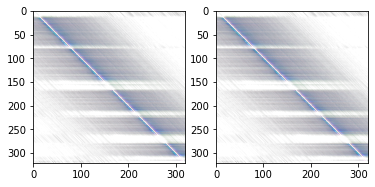

In [16]:
import matplotlib.pyplot as plt


fig = plt.figure(figsize=(6, 10))


fig, axs = plt.subplots(1, 2)
# fig.suptitle('Vertically stacked subplots')
# axs[0].plot(x, y)
# axs[1].plot(x, -y)

# modified = manual_rel.transpose(0,1).reshape([2159, 321, 4])
axs[0].imshow(MHAttention_pscores_transposed)
axs[1].imshow(manual_rel_transposed)
# axs[2].imshow(MHAttention_matmulPos)
print(MHAttention_matmulPos.shape)

In [17]:
# relative position function done, now need to figure out getting to MHAttention_matmulPos
'''
auto matmulPos = matmulNT(posEmb.as(q.type()), q);

arr = matmulPos.array();
af::saveArray("MHAttention_matmulPos", arr, savePathChar, true); 
'''
# posEmb from above
selfAttention_posEmb = af.array.read_array("OUTPUT_TRF.arr", key="selfAttention_posEmb").to_ndarray()

# q from above
MHAttention_q = af.array.read_array("OUTPUT_TRF.arr", key="MHAttention_q").to_ndarray()

# desired matmulPos
MHAttention_matmulPos = af.array.read_array("OUTPUT_TRF.arr", key="MHAttention_matmulPos").to_ndarray()

valueprint(selfAttention_posEmb)
valueprint(MHAttention_q)
valueprint(MHAttention_matmulPos)


None (1839, 384, 4) -1679.4205 0.07376087
None (321, 384, 4) 256.14188 0.022112375
None (1839, 321, 4) -85057.48 0.13692527


In [37]:
posEmb = model.mctc.encoder.layers[0].attention.self.distance_embedding.weight
# posEmb = posEmb.unsqueeze(0).repeat(4,1,1)
posEmb = posEmb
query_layer = save_dict["query_layer"]

valueprint(posEmb)
valueprint(query_layer)

None torch.Size([1839, 384]) tensor(-419.8552, grad_fn=<SumBackward0>) tensor(0.0738, grad_fn=<StdBackward0>)
None torch.Size([1, 4, 321, 384]) tensor(256.1419, grad_fn=<SumBackward0>) tensor(0.0221, grad_fn=<StdBackward0>)


In [38]:
query_format = query_layer
print(posEmb.shape)
print(query_format.shape)
# my_out = torch.bmm(posEmb, query_format)
# valueprint(my_out)
# valueprint(MHAttention_matmulPos)

torch.Size([1839, 384])
torch.Size([1, 4, 321, 384])


In [41]:
query_format = query_layer.transpose(2,3)
posEmb_format = posEmb
print(posEmb_format.shape)
print(query_format.shape)
my_out = torch.einsum('cd, abde -> abce', posEmb_format, query_format)

# my_out = torch.bmm(posEmb.unsqueeze(0), query_format.unsqueeze(0))
valueprint(my_out)
# valueprint(MHAttention_matmulPos)

torch.Size([1839, 384])
torch.Size([1, 4, 384, 321])
None torch.Size([1, 4, 1839, 321]) tensor(-85057.4531, grad_fn=<SumBackward0>) tensor(0.1369, grad_fn=<StdBackward0>)


In [45]:
query_layer = save_dict["query_layer"]
n = torch.Tensor(MHAttention_matmulPos).size(0) // 2 - 0


def reshape_fortran(x, shape):
    if len(x.shape) > 0:
        x = x.permute(*reversed(range(len(x.shape))))
    return x.reshape(*reversed(shape)).permute(*reversed(range(len(shape))))

def relativePositionEmbeddingRotate(data):
    b, d0, d1, d2 = data.shape
    
    # data = af::join(0, data, af::constant(0.0, d1, d1, d2, d3, data.type()));
    data = torch.cat((data, torch.zeros((b, d1, d1, d2))), dim=1)

    # data = af::moddims(data, af::dim4((d0 + d1) * d1, 1, d2, d3));
    # data = data.reshape()
    data = reshape_fortran(data, [b, (d0 + d1) * d1, 1, d2])
    # data = data.numpy().reshape((d0 + d1) * d1, 1, d2,order='F')


    # data = data.rows(0, (d1 + d0 - 1) * d1 - 1);
    data = data[:, :(d1 + d0 - 1) * d1]

    # data = af::moddims(data, af::dim4(d0 + d1 - 1, d1, d2, d3));
    data = reshape_fortran(data, [b, d0 + d1 - 1, d1, d2])

    return data

def rel_then_transpose(relEmbs):
    relEmbs = relEmbs[:, n:n+query_layer.size(2)].transpose(1, 2)
    return relEmbs

matmulPos = torch.Tensor(MHAttention_matmulPos).unsqueeze(0)
print("matmulPos", matmulPos.shape)
manual_rel = relativePositionEmbeddingRotate(matmulPos)
print()
valueprint(MHAttention_pscores)
valueprint(manual_rel)
print()
manual_rel_transposed = rel_then_transpose(manual_rel)
valueprint(MHAttention_pscores_transposed)
valueprint(manual_rel_transposed)

matmulPos torch.Size([1, 1839, 321, 4])

None (2159, 321, 4) -85057.44 0.12701775
None torch.Size([1, 2159, 321, 4]) tensor(-85057.4453) tensor(0.1270)

None (321, 321, 4) 57426.992 0.19243532
None torch.Size([1, 321, 321, 4]) tensor(57426.9961) tensor(0.1924)


In [2]:
# testing again after chaning MCTCSelfOutput to this differnt way flashlight seems to do things

# testing after fixing the model & weights
import torch
from transformers import MCTCForCTC, MCTCProcessor, MCTCConfig
config = MCTCConfig()
model = MCTCForCTC(config)
model.load_state_dict(torch.load("./ported_pytorch_model.bin"))
model = model.eval()
our_attn = model.mctc.encoder.layers[0].attention
first_layer = model.mctc.encoder.layers[0]


In [17]:
# lets take a deeper look.
import arrayfire as af

model = model.double()
layer_x = af.array.read_array("OUTPUT_TRF.arr", key="layer_x").to_ndarray()

def valueprint(k, name=None):
    print(name, k.shape, k.sum(), k.std())
our_output = torch.tensor(layer_x, dtype=torch.float64).unsqueeze(0).transpose(1,2)
print(our_output.shape, "INPUT")
context_layer, attention_scores, attention_probs, value_layer, save_dict = our_attn.self(our_output, output_attentions=True)

torch.Size([1, 321, 1536]) INPUT
attention_scores torch.Size([1, 4, 321, 321]) tensor(87683.4148, dtype=torch.float64, grad_fn=<SumBackward0>) tensor(0.9123, dtype=torch.float64, grad_fn=<StdBackward0>)
value_layer torch.Size([1, 4, 321, 384]) tensor(-995.1271, dtype=torch.float64, grad_fn=<SumBackward0>) tensor(0.1639, dtype=torch.float64, grad_fn=<StdBackward0>)
context_layer torch.Size([1, 4, 321, 384]) tensor(-1017.8953, dtype=torch.float64, grad_fn=<SumBackward0>) tensor(0.0613, dtype=torch.float64, grad_fn=<StdBackward0>)


In [4]:
'''
MHAttention_pscores_scores == final rel scores + query
attention_scores torch.Size([1, 4, 321, 321]) tensor(87683.4062, grad_fn=<SumBackward0>) tensor(0.9123, grad_fn=<StdBackward0>)
'''
MHAttention_pscores_scores = af.array.read_array("OUTPUT_TRF.arr", key="MHAttention_pscores_scores").to_ndarray()
valueprint(MHAttention_pscores_scores)


None (321, 321, 4) 87683.41 0.91226983


In [5]:
'''Softmax of above final pscores
'''
MHAttention_result_attn = af.array.read_array("OUTPUT_TRF.arr", key="MHAttention_result_attn").to_ndarray()
valueprint(MHAttention_result_attn)
valueprint(attention_probs)

None (321, 321, 4) 1283.9999 0.0022644862
None torch.Size([1, 4, 321, 321]) tensor(1284., grad_fn=<SumBackward0>) tensor(0.0023, grad_fn=<StdBackward0>)


In [6]:
'''Attn times value vector for attention over value layer
context_layer torch.Size([1, 4, 321, 384]) tensor(-1017.8952, grad_fn=<SumBackward0>) tensor(0.0613, grad_fn=<StdBackward0>)

auto result = matmul(attn.as(v.type()), v);

af::saveArray("MHAttention_result_result", result, savePathChar, true);

result = moddims(result, af::dim4(-1, headDim * nHeads, bsz));

af::saveArray("MHAttention_result_result_2", result, savePathChar, true);
'''
MHAttention_result_result = af.array.read_array("OUTPUT_TRF.arr", key="MHAttention_result_result").to_ndarray()
MHAttention_result_result_2 = af.array.read_array("OUTPUT_TRF.arr", key="MHAttention_result_result_2").to_ndarray()
valueprint(MHAttention_result_result)
valueprint(MHAttention_result_result_2)
valueprint(save_dict["context_layer"])
valueprint(context_layer)

None (321, 384, 4) -1017.8952 0.061281413
None (321, 1536) -1017.8952 0.061281413
None torch.Size([1, 4, 321, 384]) tensor(-1017.8952, grad_fn=<SumBackward0>) tensor(0.0613, grad_fn=<StdBackward0>)
None torch.Size([1, 321, 1536]) tensor(-1017.8953, grad_fn=<SumBackward0>) tensor(0.0613, grad_fn=<StdBackward0>)


In [7]:
context_layer, attention_scores, attention_probs, value_layer, save_dict = our_attn(our_output, output_attentions=True)

attention_scores torch.Size([1, 4, 321, 321]) tensor(87683.4062, grad_fn=<SumBackward0>) tensor(0.9123, grad_fn=<StdBackward0>)
value_layer torch.Size([1, 4, 321, 384]) tensor(-995.1271, grad_fn=<SumBackward0>) tensor(0.1639, grad_fn=<StdBackward0>)
context_layer torch.Size([1, 4, 321, 384]) tensor(-1017.8952, grad_fn=<SumBackward0>) tensor(0.0613, grad_fn=<StdBackward0>)
SelfOUtput input torch.Size([1, 321, 1536]) tensor(-1017.8953, grad_fn=<SumBackward0>) tensor(0.0613, grad_fn=<StdBackward0>)
SelfOUtput prenorm torch.Size([1, 1536, 321]) tensor(368.7508, grad_fn=<SumBackward0>) tensor(0.0417, grad_fn=<StdBackward0>)
SelfOUtput input_tensor torch.Size([1, 321, 1536]) tensor(330.5734)


RuntimeError: The size of tensor a (321) must match the size of tensor b (1536) at non-singleton dimension 2

In [8]:
'''selfAttn result (same as above)
SelfOUtput input torch.Size([1, 321, 1536]) tensor(-1017.8953, grad_fn=<SumBackward0>)
'''
selfAttention_result = af.array.read_array("OUTPUT_TRF.arr", key="selfAttention_result").to_ndarray()
valueprint(selfAttention_result)


None (321, 1536) -1017.8952 0.061281413


In [9]:
'''wf*selfAttn result

af::saveArray("selfAttention_result", arr, savePathChar, true); 

result = (*wf_)(transpose(result));

arr = result.array();

af::saveArray("selfAttention_result_2", arr, savePathChar, true); 

SelfOUtput prenorm torch.Size([1, 321, 1536]) tensor(-46.2676, grad_fn=<SumBackward0>)
'''
selfAttention_wf_ = af.array.read_array("OUTPUT_TRF.arr", key="selfAttention_wf_").to_ndarray()
selfAttention_result_2 = af.array.read_array("OUTPUT_TRF.arr", key="selfAttention_result_2").to_ndarray()
valueprint(selfAttention_wf_)
# valueprint(selfAttention_result_2)


None (1536, 1536) -44.906384 0.017451134


In [18]:
my_wf = model.mctc.encoder.layers[0].attention.output.dense.weight
my_result = context_layer

valueprint(selfAttention_wf_)
valueprint(my_wf)
print()
valueprint(selfAttention_result)
valueprint(my_result)

None (1536, 1536) -44.906384 0.017451134
None torch.Size([1536, 1536]) tensor(-44.9064, dtype=torch.float64, grad_fn=<SumBackward0>) tensor(0.0175, dtype=torch.float64, grad_fn=<StdBackward0>)

None (321, 1536) -1017.8952 0.061281413
None torch.Size([1, 321, 1536]) tensor(-1017.8953, dtype=torch.float64, grad_fn=<SumBackward0>) tensor(0.0613, dtype=torch.float64, grad_fn=<StdBackward0>)


In [23]:
diff = selfAttention_result - my_result.detach().numpy()
print(diff.sum(), diff.mean())

5.745828752590221e-05 1.1653501331674741e-10


In [25]:
# hidden_states = torch.einsum('hh, he -> he', torch.Tensor(selfAttention_wf_), torch.Tensor(selfAttention_result).transpose(-1, -2))
hidden_states_gold = torch.matmul(torch.tensor(my_wf, dtype=torch.float64), torch.tensor(selfAttention_result, dtype=torch.float64).transpose(-1, -2))
hidden_states_mine = torch.matmul(torch.tensor(my_wf, dtype=torch.float64), torch.tensor(my_result, dtype=torch.float64).transpose(-1, -2))
valueprint(selfAttention_result_2)
valueprint(hidden_states_gold)
valueprint(hidden_states_mine)

None (1536, 321) 25.706522 0.1094709
None torch.Size([1536, 321]) tensor(25.7065, dtype=torch.float64) tensor(0.1095, dtype=torch.float64)
None torch.Size([1, 1536, 321]) tensor(368.7508, dtype=torch.float64) tensor(0.0417, dtype=torch.float64)


/tmp/ipykernel_5860/1584567683.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  hidden_states_gold = torch.matmul(torch.tensor(my_wf, dtype=torch.float64), torch.tensor(selfAttention_result, dtype=torch.float64).transpose(-1, -2))
/tmp/ipykernel_5860/1584567683.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  hidden_states_mine = torch.matmul(torch.tensor(my_wf, dtype=torch.float64), torch.tensor(my_result, dtype=torch.float64).transpose(-1, -2))


5.745828752590221e-05


<Figure size 144x1440 with 0 Axes>

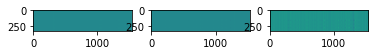

In [31]:
import matplotlib.pyplot as plt


fig = plt.figure(figsize=(2, 20))


fig, axs = plt.subplots(1, 3)
# fig.suptitle('Vertically stacked subplots')
# axs[0].plot(x, y)
# axs[1].plot(x, -y)

# modified = manual_rel.transpose(0,1).reshape([2159, 321, 4])
axs[0].imshow(selfAttention_result**3)
axs[1].imshow(my_result.squeeze(0).detach().numpy() **3)
# axs[2].imshow(MHAttention_matmulPos)
diff = selfAttention_result - my_result.squeeze(0).detach().numpy()
axs[2].imshow(diff)
print(diff.sum())
